In [1]:
!pip install tensorflow
!pip install scikit-learn

# Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


In [3]:
import sys
sys.path.append('../../') 
from utilities import dataframe_utils as dfu

In [4]:
data_df = pd.read_csv("https://project-2-rice.s3.us-east-2.amazonaws.com/sp500_adj_close_raw.csv")

In [5]:
data_df.shape

(1979679, 14)

In [6]:
# remove the last day
def split_dataset_by_date(raw_data: pd.DataFrame, todays_date: str):
    # Filter data by today's date
    filter_data_by_date = raw_data["Date"] == todays_date
    
    # Create a new dataframe with today's data
    todays_data = raw_data[filter_data_by_date].reset_index(drop=True)
    
    # Create a new dataframe with historical data (excluding today's data)
    historical_data = raw_data[~filter_data_by_date].reset_index(drop=True)
    
    return historical_data, todays_data


data_df, todays_data = split_dataset_by_date(data_df, "2024-10-23")

In [7]:
# # Load stock data
data_df.sort_values(by='Date', ascending=False, inplace=True)
data_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
1979177,2024-10-22,ZTS,189.51,-0.002744,0.010508,43.550476,189.202800,182.936800,179.423950,196.46294,186.77606,180.90000,196.48,sell
1978848,2024-10-22,EVRG,61.51,0.007479,0.007007,52.020184,60.149788,57.229534,53.876423,62.58823,58.86077,57.85000,62.01,hold
1978835,2024-10-22,EMN,107.06,-0.001214,0.012436,36.939960,104.169580,100.843605,95.823300,113.07432,106.59568,94.85885,113.77,short
1978836,2024-10-22,EMR,109.48,-0.008951,0.015834,46.884840,105.856200,107.908720,106.833990,113.56785,106.60315,98.19000,112.64,short
1978837,2024-10-22,ENPH,92.23,-0.149843,0.026403,22.967970,110.297000,111.497600,113.599200,119.76680,85.79620,90.42000,123.65,sell


## Set Indices

In [8]:
data_df = data_df.drop(columns=['Action'])
data_df.set_index(['Date', 'Ticker'], inplace=True)

In [9]:
data_df.head()

Adjusted Close    Return  Volatility        RSI  \
Date       Ticker                                                    
2024-10-22 ZTS             189.51 -0.002744    0.010508  43.550476   
           EVRG             61.51  0.007479    0.007007  52.020184   
           EMN             107.06 -0.001214    0.012436  36.939960   
           EMR             109.48 -0.008951    0.015834  46.884840   
           ENPH             92.23 -0.149843    0.026403  22.967970   

                       SMA_50     SMA_100     SMA_200  Upper Band  Lower Band  \
Date       Ticker                                                               
2024-10-22 ZTS     189.202800  182.936800  179.423950   196.46294   186.77606   
           EVRG     60.149788   57.229534   53.876423    62.58823    58.86077   
           EMN     104.169580  100.843605   95.823300   113.07432   106.59568   
           EMR     105.856200  107.908720  106.833990   113.56785   106.60315   
           ENPH    110.297000  111.497600  113.599200   119.76680    85.79620   

                     Support  Resistance  
Date       Ticker                         
2024-10-22 ZTS     180.90000      196.48  
           EVRG     57.85000       62.01  
           EMN      94.85885      113.77  
           EMR      98.19000      112.64  
           ENPH     90.42000      123.65

In [10]:
data_df.shape

(1979178, 11)

In [11]:
# Drop resistance and sma 50 columns
data_df = data_df.drop(columns=['Resistance', 'SMA_50', 'Support'])

In [12]:
# Create features and target
X = data_df.drop(columns=['Return'])  # 'target' is the column you're predicting
y = data_df['Return']


# Split data into training and testing sets
# this is good for now  - From Metin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (neural networks usually perform better when features are scaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
data_df.head()

Adjusted Close    Return  Volatility        RSI  \
Date       Ticker                                                    
2024-10-22 ZTS             189.51 -0.002744    0.010508  43.550476   
           EVRG             61.51  0.007479    0.007007  52.020184   
           EMN             107.06 -0.001214    0.012436  36.939960   
           EMR             109.48 -0.008951    0.015834  46.884840   
           ENPH             92.23 -0.149843    0.026403  22.967970   

                      SMA_100     SMA_200  Upper Band  Lower Band  
Date       Ticker                                                  
2024-10-22 ZTS     182.936800  179.423950   196.46294   186.77606  
           EVRG     57.229534   53.876423    62.58823    58.86077  
           EMN     100.843605   95.823300   113.07432   106.59568  
           EMR     107.908720  106.833990   113.56785   106.60315  
           ENPH    111.497600  113.599200   119.76680    85.79620

## Neural Networks

In [14]:


# Define the neural network architecture
# model = Sequential()

# # Add layers: Input layer, hidden layers, and output layer
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer and first hidden layer
# model.add(Dense(32, activation='relu'))  # Second hidden layer
# model.add(Dense(1, activation='linear'))  # Output layer for regression

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # Train the model
# history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32)


In [15]:
# history.model.summary()

In [16]:
# def model_eval(model, X_test_scaled, y_test):
#     # Evaluate the model
#     train_loss, train_mae = model.predict(X_train_scaled, y_train, verbose=0)
#     test_loss, test_mae = model.predict(X_test_scaled, y_test, verbose=0)

#     print(f'Training Mean Absolute Error: {train_mae:.2f}')
#     print(f'Testing Mean Absolute Error: {test_mae:.2f}')

In [17]:
# # Evaluate the model on the test data
# test_loss, test_mae = model.evaluate()

# # use model predict
# # Predict on the test set
# y_pred_log_reg = model.predict(X_test_scaled)

# # Evaluate logistic regression model
# # mse_log_reg = mean_squared_error(y_, y_pred_log_reg)
# # print(f"Logistic Regression Mean Squared Error: {mse_log_reg}")


# # focus on confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# # confusion_matrix(y_test_binary, y_pred_log_reg)
# print(classification_report(y_test_binary, y_pred_log_reg))

# print(f"Test Mean Absolute Error: {test_mae}")
# print(f"Test Loss: {test_loss}")

## Logistic Regression

In [21]:


# For logistic regression, you might want to binarize the target (e.g., predict up/down movement)
y_train_binary = (y_train > y_train.median()).astype(int)
y_test_binary = (y_test > y_test.median()).astype(int)
# y_train_binary = (y_train > 0).astype(int)
# y_test_binary = (y_test > 0).astype(int)

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train_binary)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate logistic regression model
# mse_log_reg = mean_squared_error(y_test_binary, y_pred_log_reg)
# print(f"Logistic Regression Mean Squared Error: {mse_log_reg}")


# focus on confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
# confusion_matrix(y_test_binary, y_pred_log_reg)
print(classification_report(y_test_binary, y_pred_log_reg))



# recall should be somewhere around 50 but it means

# todo look up
# Jim Simons, the founder of Renaissance Technologies, is a former mathematician and code breaker who founded the hedge fund in 1982. He is known for his quantitative trading strategies and the use of mathematical models to predict price movements in financial markets. Renaissance Technologies is one of the most successful hedge funds in the world, with an average annual return of 66% over a 30-year period. The firm's flagship Medallion Fund has generated returns of over 66% per year since its inception in 1988, making it one of the most successful hedge funds in history. The fund is known for its use of sophisticated computer algorithms and mathematical models to predict price movements in financial markets. The firm's success has made Jim Simons one of the richest people in the world, with an estimated net worth of $23.5 billion.

              precision    recall  f1-score   support

           0       0.51      0.51      0.51    197918
           1       0.51      0.50      0.50    197918

    accuracy                           0.51    395836
   macro avg       0.51      0.51      0.51    395836
weighted avg       0.51      0.51      0.51    395836



In [29]:
# todays_data = todays_data.drop(columns=['Action'])
# todays_data.set_index(['Date', 'Ticker'], inplace=True)

todays_data.drop(columns=['Resistance', 'SMA_50', 'Support'], inplace=True)

# todays_data = todays_data.drop(columns=['Return']) 

# todays_data



In [30]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(todays_data)

# Predict on the test set
today_prediction = log_reg.predict(data_scaled)
today_prediction

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,

In [31]:
len(today_prediction)

501

In [36]:
prediction_df = pd.DataFrame()
prediction_df['Ticker'] = todays_data.index.get_level_values(1)
prediction_df['Prediction'] = today_prediction
prediction_df.head(20)

# prediction_df.to_csv('prediction.csv', index=False)

,Ticker,Prediction
0,A,1
1,AAPL,0
2,ABBV,1
3,ABNB,0
4,ABT,0
5,ACGL,1
6,ACN,0
7,ADBE,1
8,ADI,1
9,ADM,1


# Look at Cumulative Equity Curve

In [ ]:
df['realized_return'] = df['Return'] * df['Action'] # buy and sell
df['return'] = df['Return'] # HODL buy and hold




```Example:
    Apple return is 5%
    5% * 1 = 5%
    Apple return is -5% 
    -5% * 1 = -5%
    Apple return is -5%
    -5% * -1 = 5%
    
    daily_return = df['realized_return'].groupby('Date').mean()
    cumulative_return = daily_return.cumsum() 
    1.01 * 1.01 * 1.01 = 1.03```

# Confusion Matrix

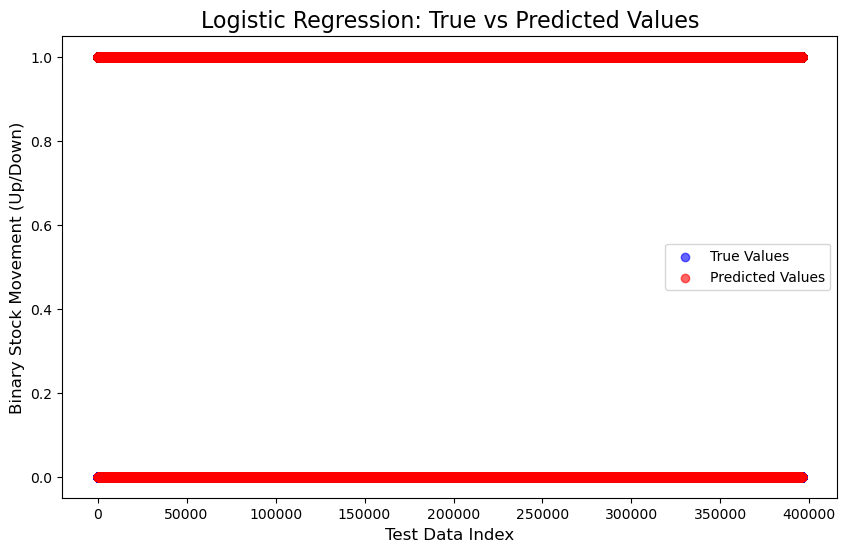

In [35]:
import matplotlib.pyplot as plt

# Create a scatter plot for visualizing predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_binary)), y_test_binary, color='blue', label='True Values', alpha=0.6)
plt.scatter(range(len(y_pred_log_reg)), y_pred_log_reg, color='red', label='Predicted Values', alpha=0.6)

# Add title and labels
plt.title('Logistic Regression: True vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Index', fontsize=12)
plt.ylabel('Binary Stock Movement (Up/Down)', fontsize=12)
plt.legend()

# Display the plot
plt.show()

In [25]:
# MAE for Neural Network
_, neural_net_mae = model.evaluate(X_test_scaled, y_test)

# MAE for Logistic Regression (you may need to adjust this to accuracy if it’s a binary classification)
from sklearn.metrics import accuracy_score
log_reg_accuracy = accuracy_score(y_test_binary, y_pred_log_reg)

print(f"Neural Network MAE: {neural_net_mae}")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")


12373/12373 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step - loss: 5.0928e-04 - mae: 0.0142
Neural Network MAE: 0.014183689840137959
Logistic Regression Accuracy: 0.5079406772811768
